<a id='Environment_Setup'></a>

# Environment Setup



In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import plot_confusion_matrix

from sklearn.preprocessing import StandardScaler
from catboost import CatBoostClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from xgboost import XGBClassifier



<a id='Constants'></a>
## Constants

In [2]:
TRAIN_PATH = "train.csv"
TEST_PATH = "test.csv"

<a id='Functions'></a>
## Functions

In [3]:
def replace_titles(x):
    title=x['Title']
    if title in ['Don', 'Major', 'Capt', 'Jonkheer', 'Rev', 'Col']:
        return 'Mr'
    elif title in ['Countess', 'Mme']:
        return 'Mrs'
    elif title in ['Mlle', 'Ms']:
        return 'Miss'
    elif title =='Dr':
        if x['Sex']=='Male':
            return 'Mr'
        else:
            return 'Mrs'
    else:
        return title
    
def substrings_in_string(big_string, substrings):
    for substring in substrings:
        if str.find(big_string, substring) != -1:
            return substring
    print (big_string)
    return np.nan

<a id='Data_Reading'></a>

# Data Reading

In [4]:
train = pd.read_csv(TRAIN_PATH)
test = pd.read_csv(TEST_PATH)
train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


<a id='Data Expolration'></a>
<html>
<body>
    <div style="background-color:rgba(187,126,140, 0.2); border-radius: 5px;">
        <h1 style="color:#4E5166; padding:15px;">1. Data Expolration</h1>
    </div>
</body>
</html>

<a id='Data_Cleaning'></a>
## 1.1. Data Cleaning

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [6]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [7]:
print('\x1b[1;03;8;46m' + "Number of duplicated Records in train: " +  str(sum(train.duplicated())))

Number of duplicated Records in train: 0


In [8]:
train['PassengerId'] = train['PassengerId'].apply(str)

In [9]:
train.dropna(subset='Embarked', inplace=True)
train['Cabin'].fillna('Unknown', inplace = True)

In [10]:
train.loc[train['Age'] <1, 'Age'] = 0
train['Age'].fillna(0, inplace = True)

In [11]:
temp = train['Name'].apply(lambda x: x.split(','))
train['LastName'] = temp.apply(lambda x: x[0])
temp = temp.apply(lambda x: x[1].split('.'))
train['FirstName'] = temp.apply(lambda x: x[1][1:])
train['Title'] = temp.apply(lambda x: x[0][1:])
train.drop(columns=['Name'], inplace = True)

In [12]:
train['Title']= train.apply(replace_titles, axis=1)

In [13]:
cabin_list = ['A', 'B', 'C', 'D', 'E', 'F', 'T', 'G', 'Unknown']
train['Deck']=train['Cabin'].map(lambda x: substrings_in_string(x, cabin_list))

In [14]:
train['FamilySize']=train['SibSp']+train['Parch']

## 1.2. Descriptive Analysis

In [15]:
train.drop(columns='Survived').describe().T

,count,mean,std,min,25%,50%,75%,max
Pclass,889.0,2.311586,0.834700,1.0,2.0000,3.0000,3.0,3.0000
Age,889.0,23.734533,17.570349,0.0,6.0000,24.0000,35.0,80.0000
SibSp,889.0,0.524184,1.103705,0.0,0.0000,0.0000,1.0,8.0000
Parch,889.0,0.382452,0.806761,0.0,0.0000,0.0000,0.0,6.0000
Fare,889.0,32.096681,49.697504,0.0,7.8958,14.4542,31.0,512.3292
FamilySize,889.0,0.906637,1.614703,0.0,0.0000,0.0000,1.0,10.0000


In [16]:
pd.DataFrame(train['Age'].mask(train['Age'] == 0).describe()).T

,count,mean,std,min,25%,50%,75%,max
Age,705.0,29.929078,14.273901,1.0,21.0,28.0,38.0,80.0


Text(0.5, 1.0, 'Variable Correlation')

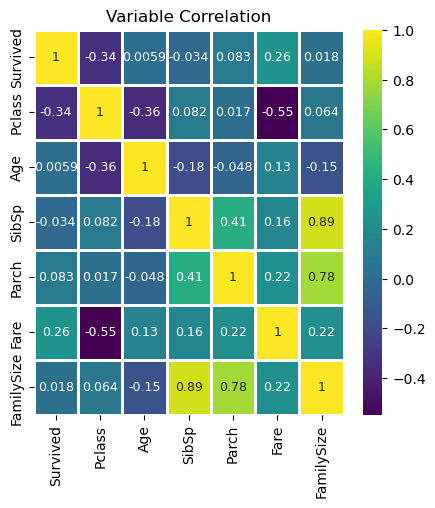

In [17]:
plt.figure(figsize=(5,5))
sns.heatmap(train.corr(),cmap = 'viridis',linewidth = 1,annot= True, annot_kws={"size": 9})
plt.title('Variable Correlation')

> - It is clear that Far and Pclass have a negative and meaningful correlation
> - A high correlation between Family size and Parch and Sibsp can be observed since they developed from Parch and Sibsp. As a result, Sibsp and Parch will be removed from the data


Text(0.5, 1.0, 'Variable Correlation')

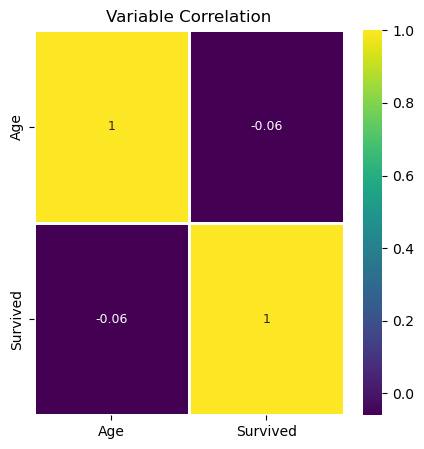

In [18]:
plt.figure(figsize=(5,5))
sns.heatmap(train.mask(train['Age'] == 0)[['Age','Survived']].corr(),cmap = 'viridis',linewidth = 1,annot= True, annot_kws={"size": 9})
plt.title('Variable Correlation')

> Since Age included zero value, which is meaningful for this feature, these values were masked for more accurate correlations

In [19]:
# Frequency
stats_df = train \
.groupby('Fare') \
['Fare'] \
.agg('count') \
.pipe(pd.DataFrame) \
.rename(columns = {'Fare': 'frequency'})

# PDF
stats_df['pdf'] = stats_df['frequency'] / sum(stats_df['frequency'])

# CDF
stats_df['cdf'] = stats_df['pdf'].cumsum()
stats_df = stats_df.reset_index()
stats_df.head(3)

,Fare,frequency,pdf,cdf
0,0.0000,15,0.016873,0.016873
1,4.0125,1,0.001125,0.017998
2,5.0000,1,0.001125,0.019123


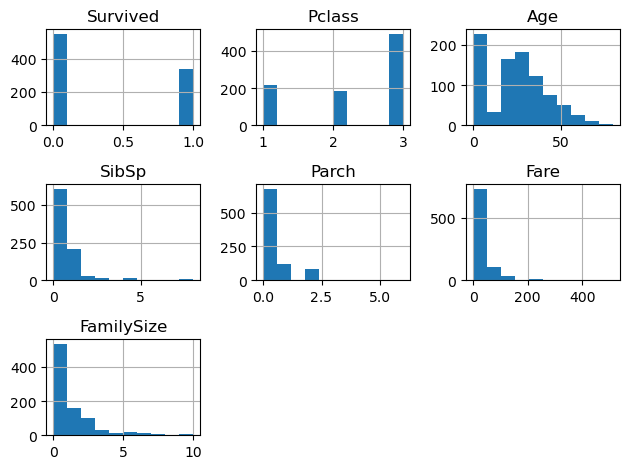

In [20]:
train.hist()
plt.tight_layout()

In [21]:
pd.DataFrame(train.groupby(['Fare','Ticket'])['Pclass'].apply(np.unique))


Pclass
Fare     Ticket         
0.0000   112050      [1]
         112052      [1]
         112058      [1]
         112059      [1]
         19972       [1]
...                  ...
227.5250 PC 17757    [1]
247.5208 PC 17558    [1]
262.3750 PC 17608    [1]
263.0000 19950       [1]
512.3292 PC 17755    [1]

[681 rows x 1 columns]

> Because each ticket has a fare, "ticket" can be considered a duplicate feature and should be removed as it does not add any further information

In [23]:
train.drop(columns=['Parch', 'SibSp', 'Cabin', 'LastName', 'FirstName', 'Ticket'], inplace=True)
train.head(3)

,PassengerId,Survived,Pclass,Sex,Age,Fare,Embarked,Title,Deck,FamilySize
0,1,0,3,male,22.0,7.2500,S,Mr,Unknown,1
1,2,1,1,female,38.0,71.2833,C,Mrs,C,1
2,3,1,3,female,26.0,7.9250,S,Miss,Unknown,0


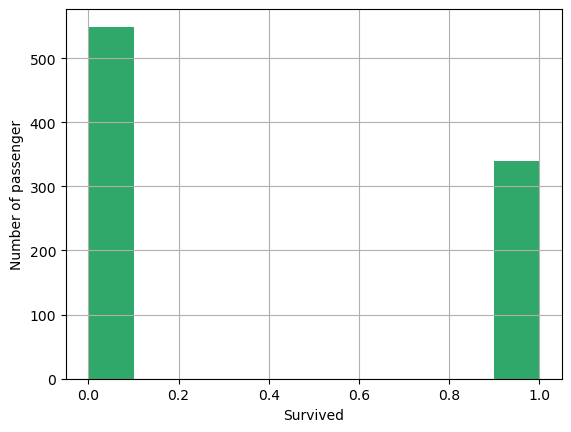

In [27]:
ax = train['Survived'].hist(color=(0.188,0.66,0.413))
ax.set_xlabel("Survived")
ax.set_ylabel("Number of passenger")
plt.show()

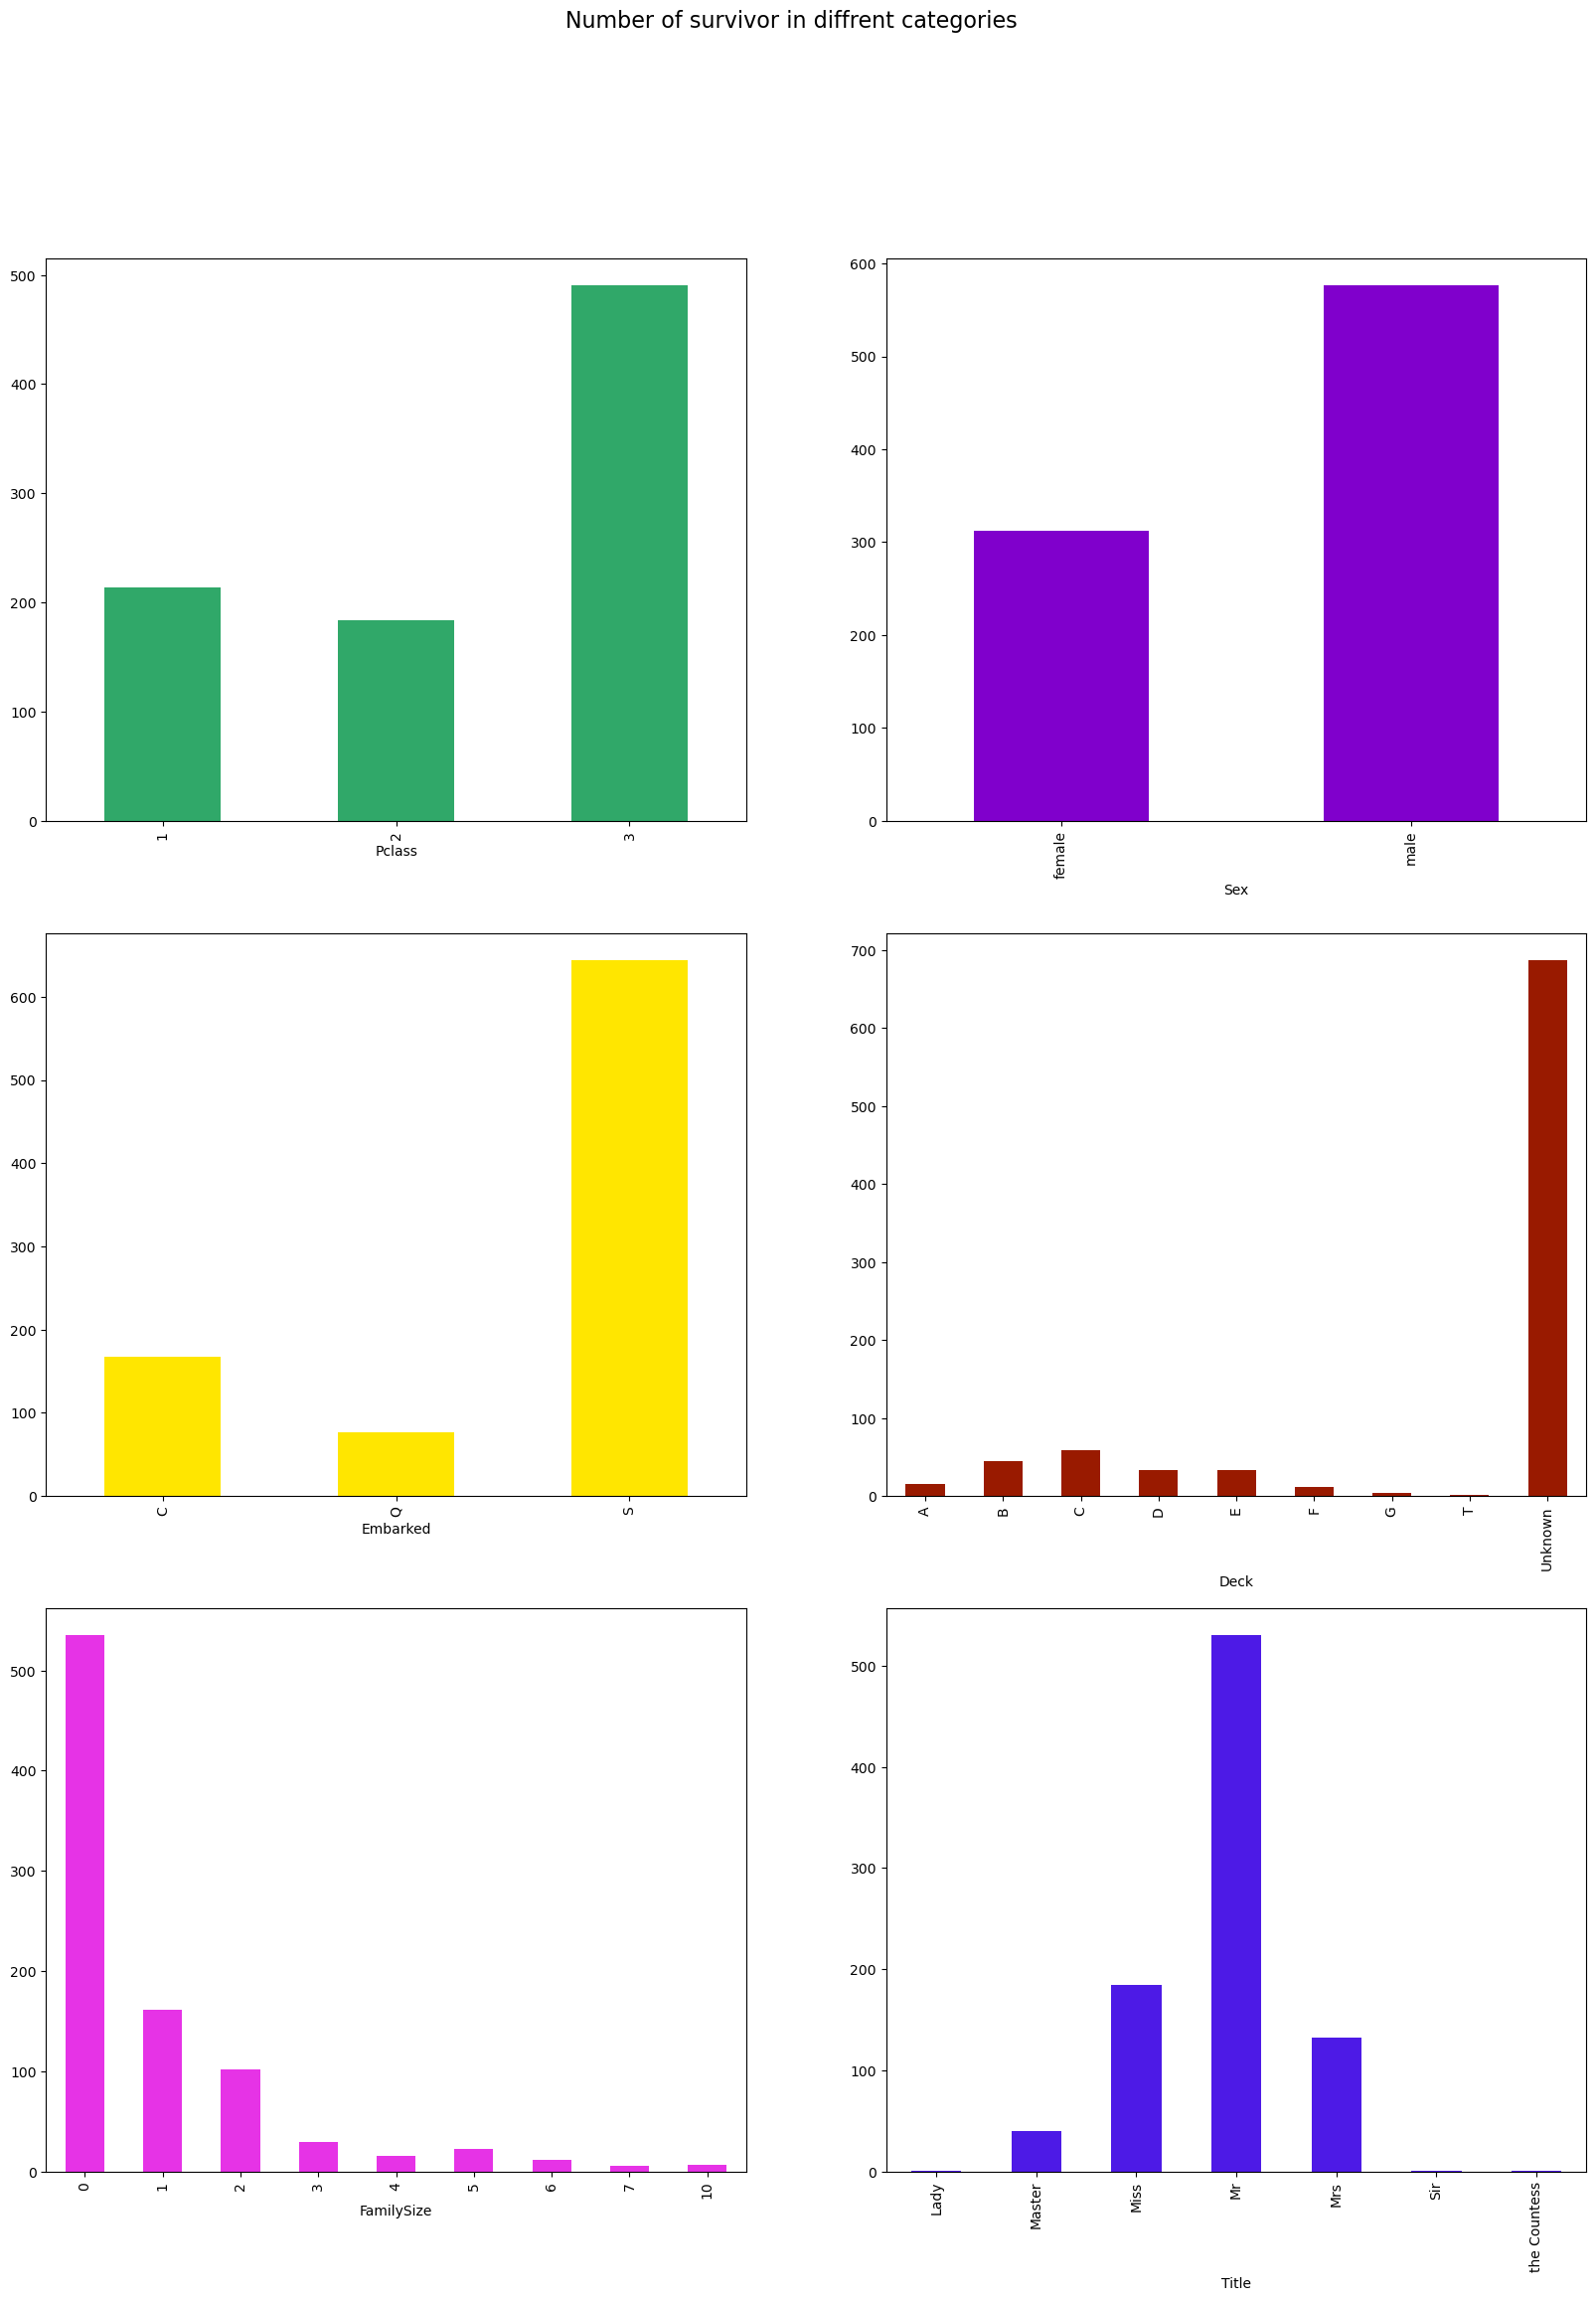

In [28]:
bins = np.arange(2) - 0.5
fig, axes = plt.subplots(nrows=3, ncols=2,figsize=(20, 25))
train.groupby('Pclass').count()['Survived'].plot(kind='bar', ax=axes[0,0], color=(0.188,0.66,0.413)) 
train.groupby('Sex').count()['Survived'].plot(kind='bar', ax=axes[0,1], color=(0.5,0,0.8)) 
train.groupby('Embarked').count()['Survived'].plot(kind='bar', ax=axes[1,0], color=(1,0.9,0)) 
train.groupby('Deck').count()['Survived'].plot(kind='bar', ax=axes[1,1], color=(0.6,0.1,0)) 
train.groupby('FamilySize').count()['Survived'].plot(kind='bar', ax=axes[2,0], color=(0.9,0.2,0.9)) 
train.groupby('Title').count()['Survived'].plot(kind='bar', ax=axes[2,1], color=(0.3,0.1,0.9)) 
fig.suptitle('Number of survivor in diffrent categories', fontsize=16)
plt.show()


In [29]:
train['Age'] = train['Age'].apply(int)

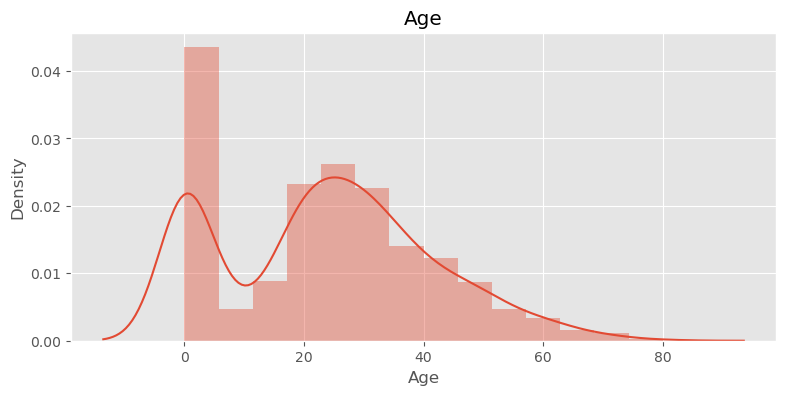

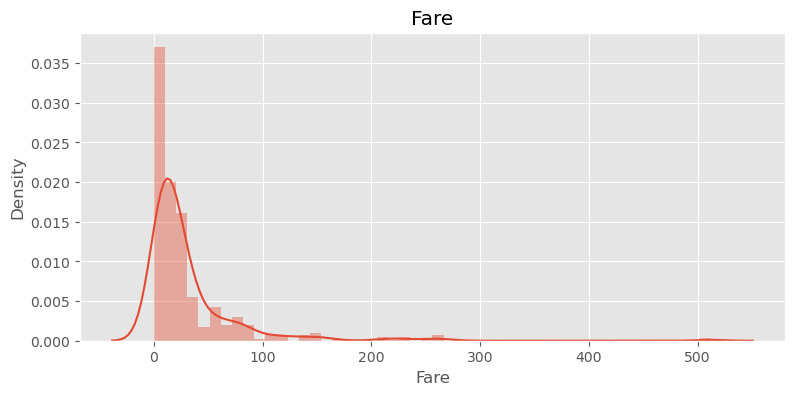

In [30]:
plt.style.use("ggplot")
for column in ['Age', 'Fare']:
    plt.figure(figsize=(20,4))
    plt.subplot(121)
    sns.distplot(train[column], kde=True)
    plt.title(column)

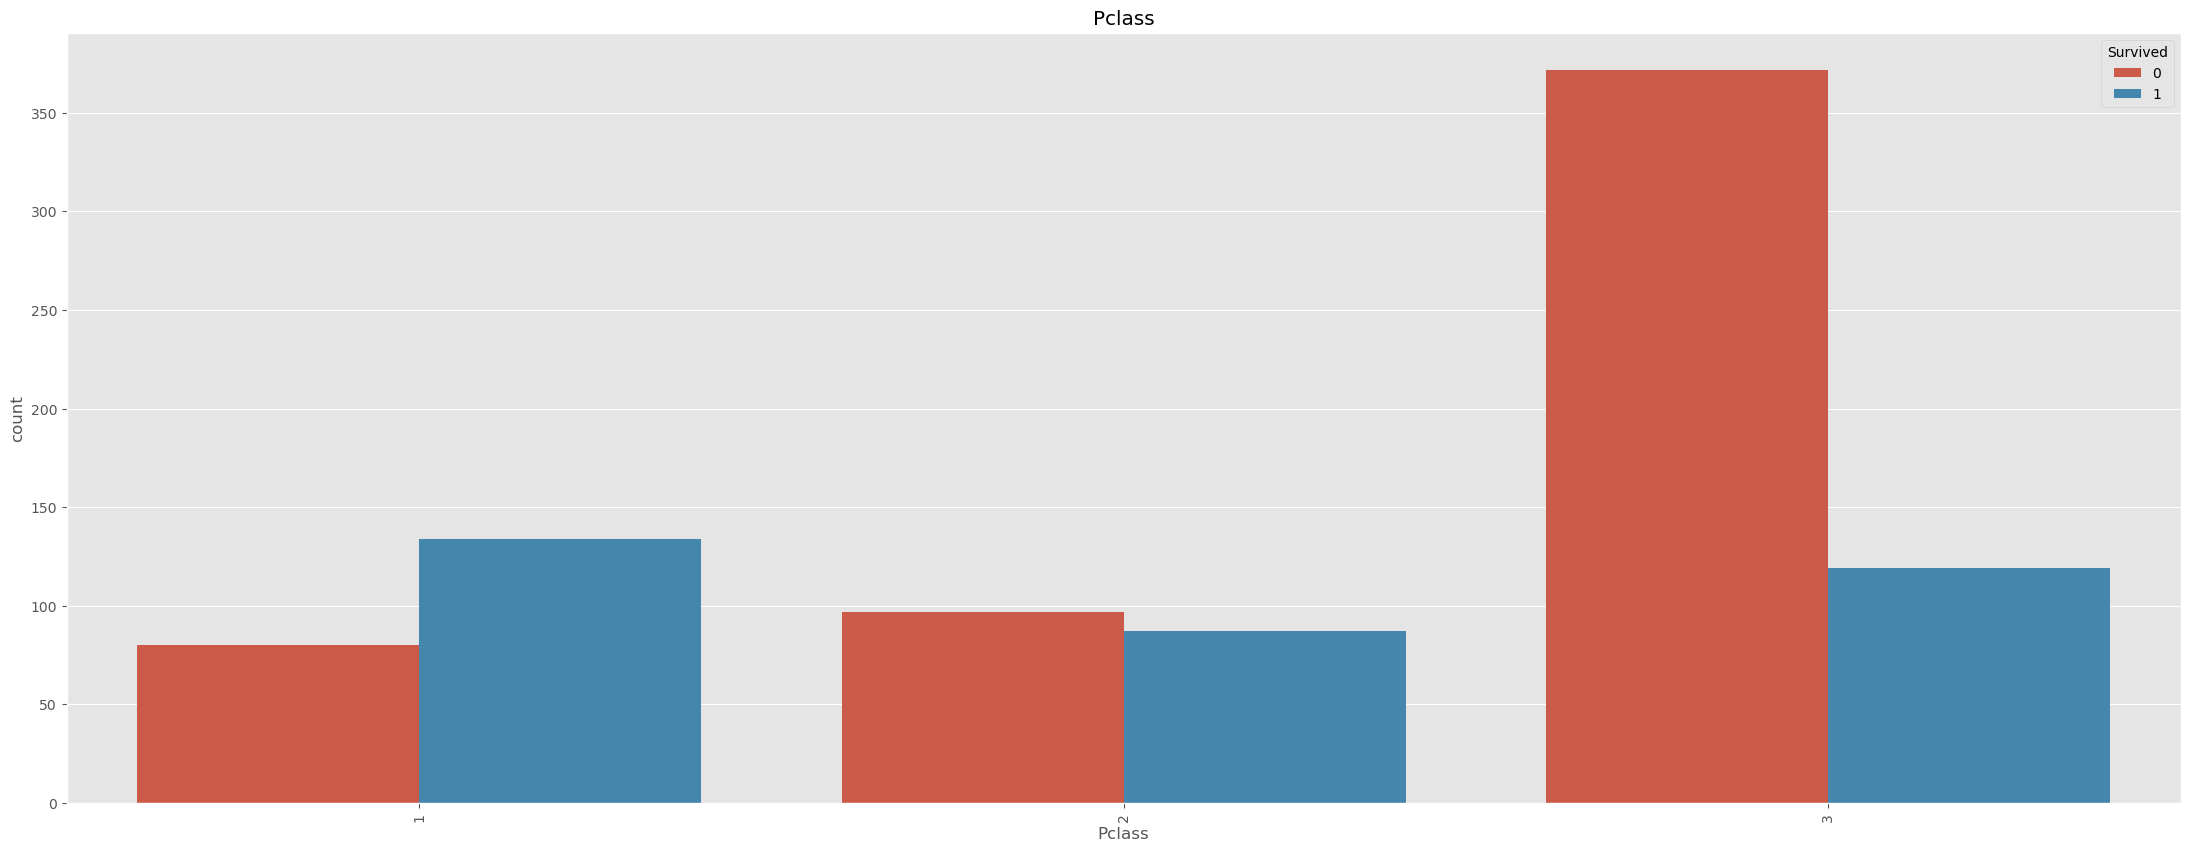

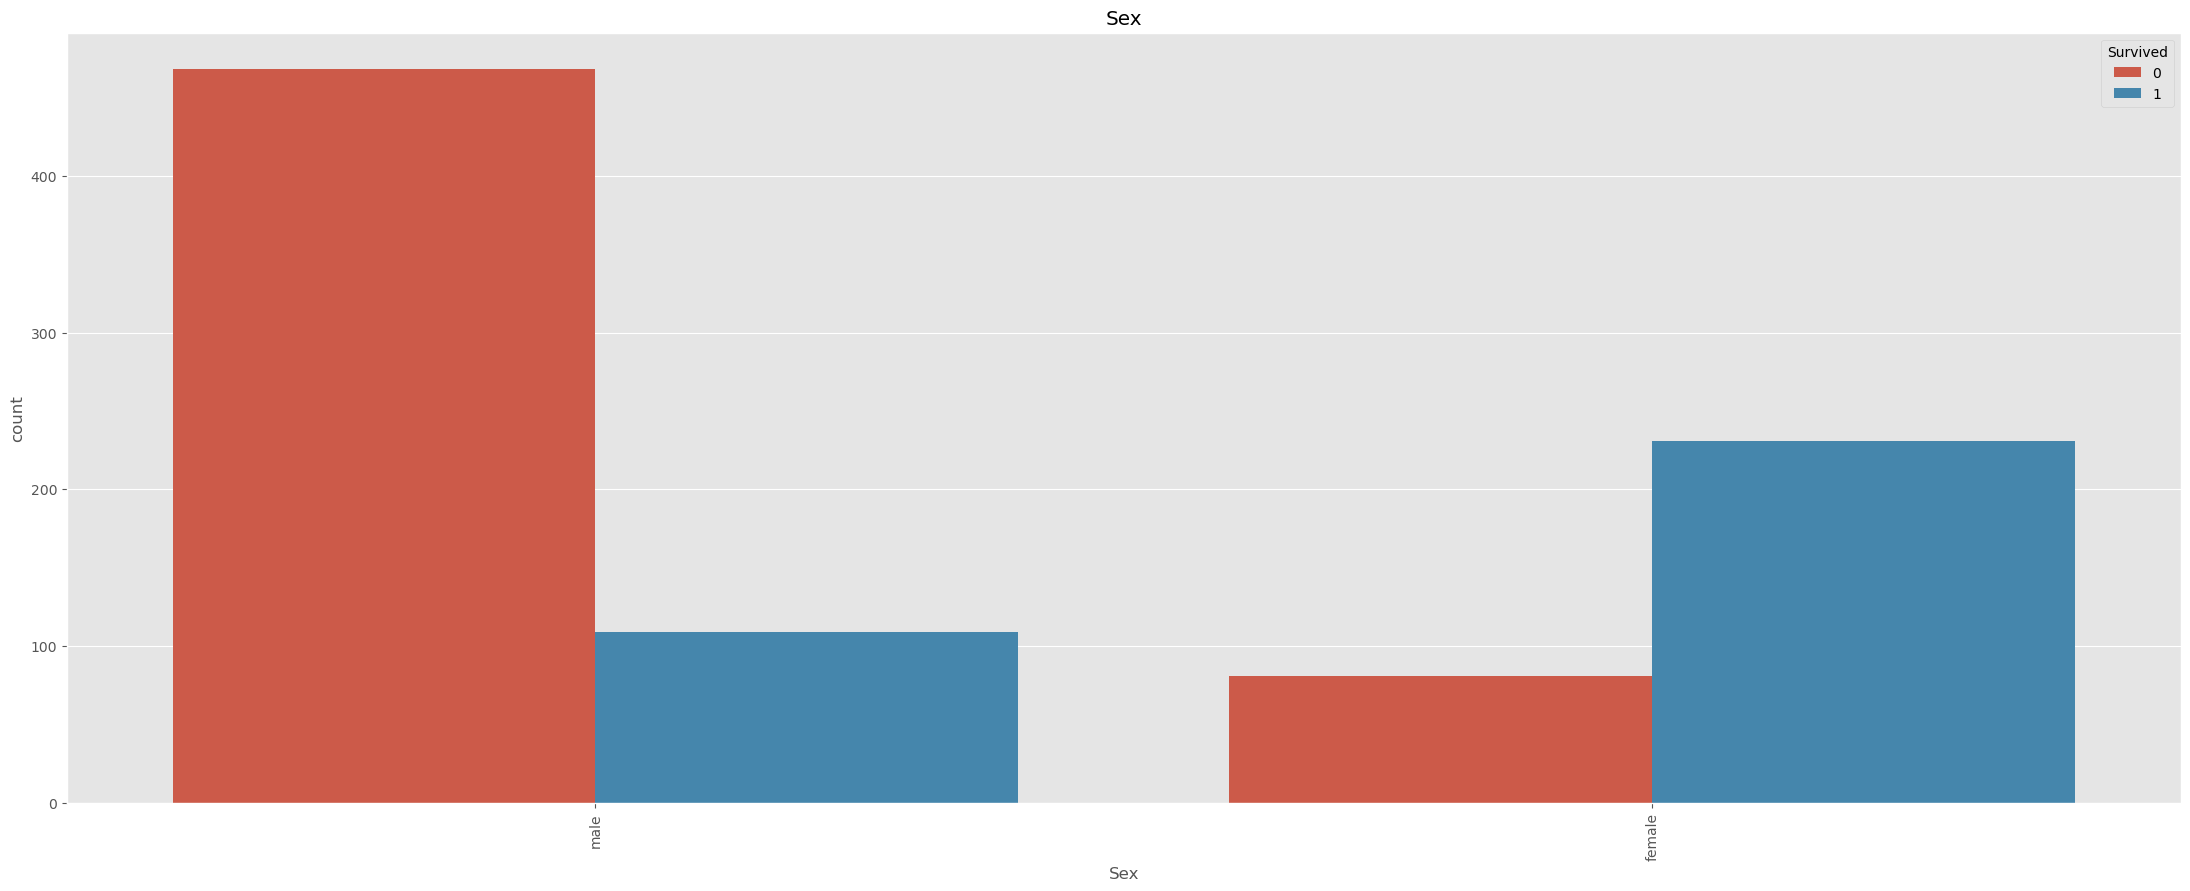

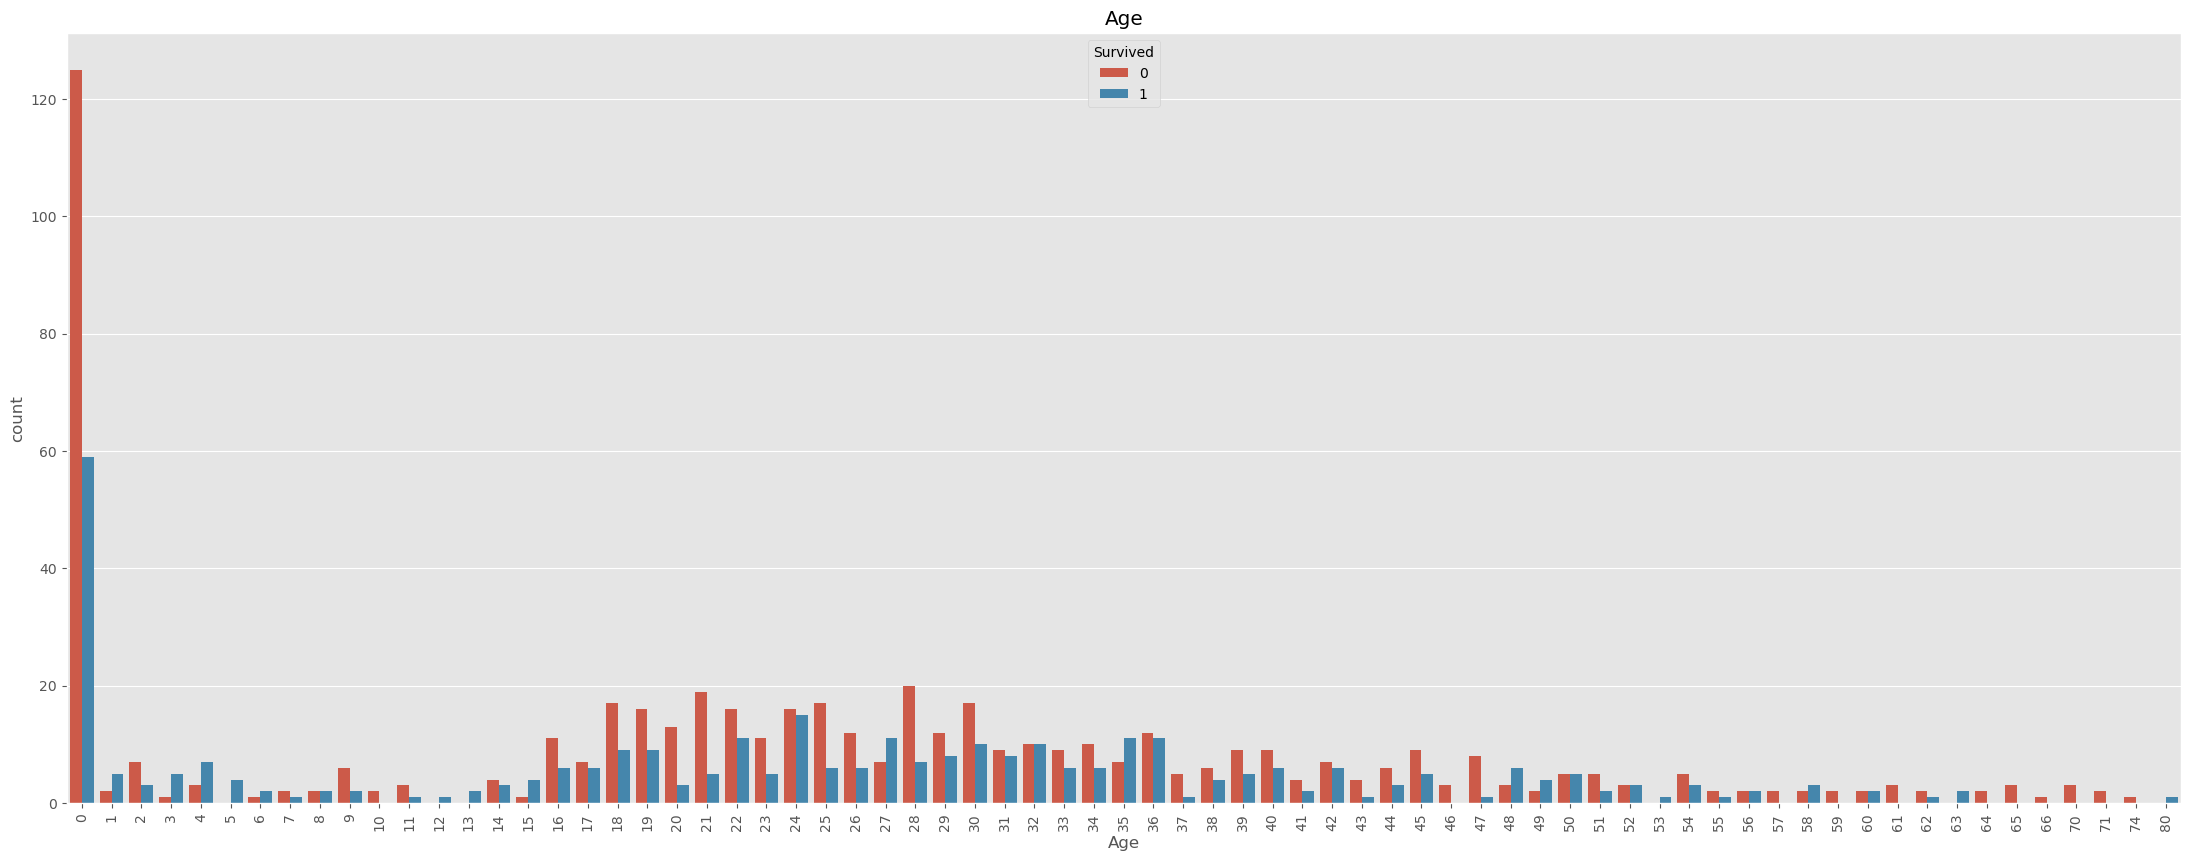

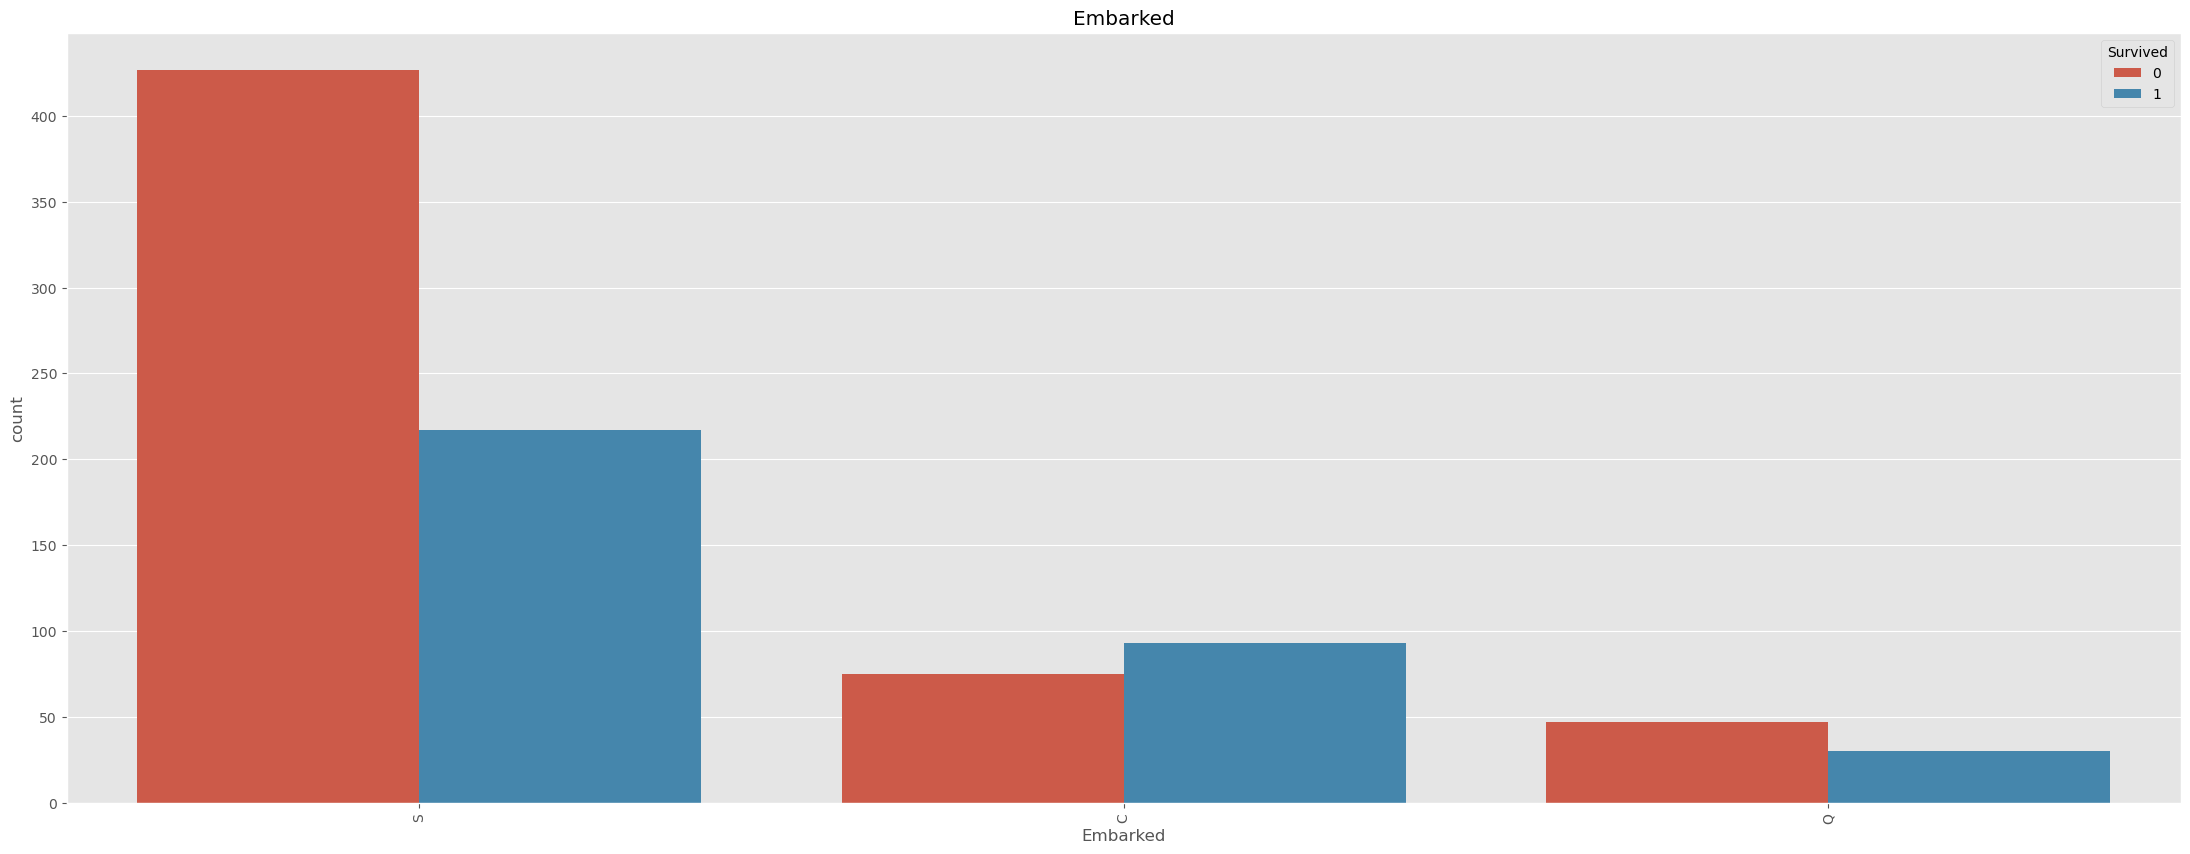

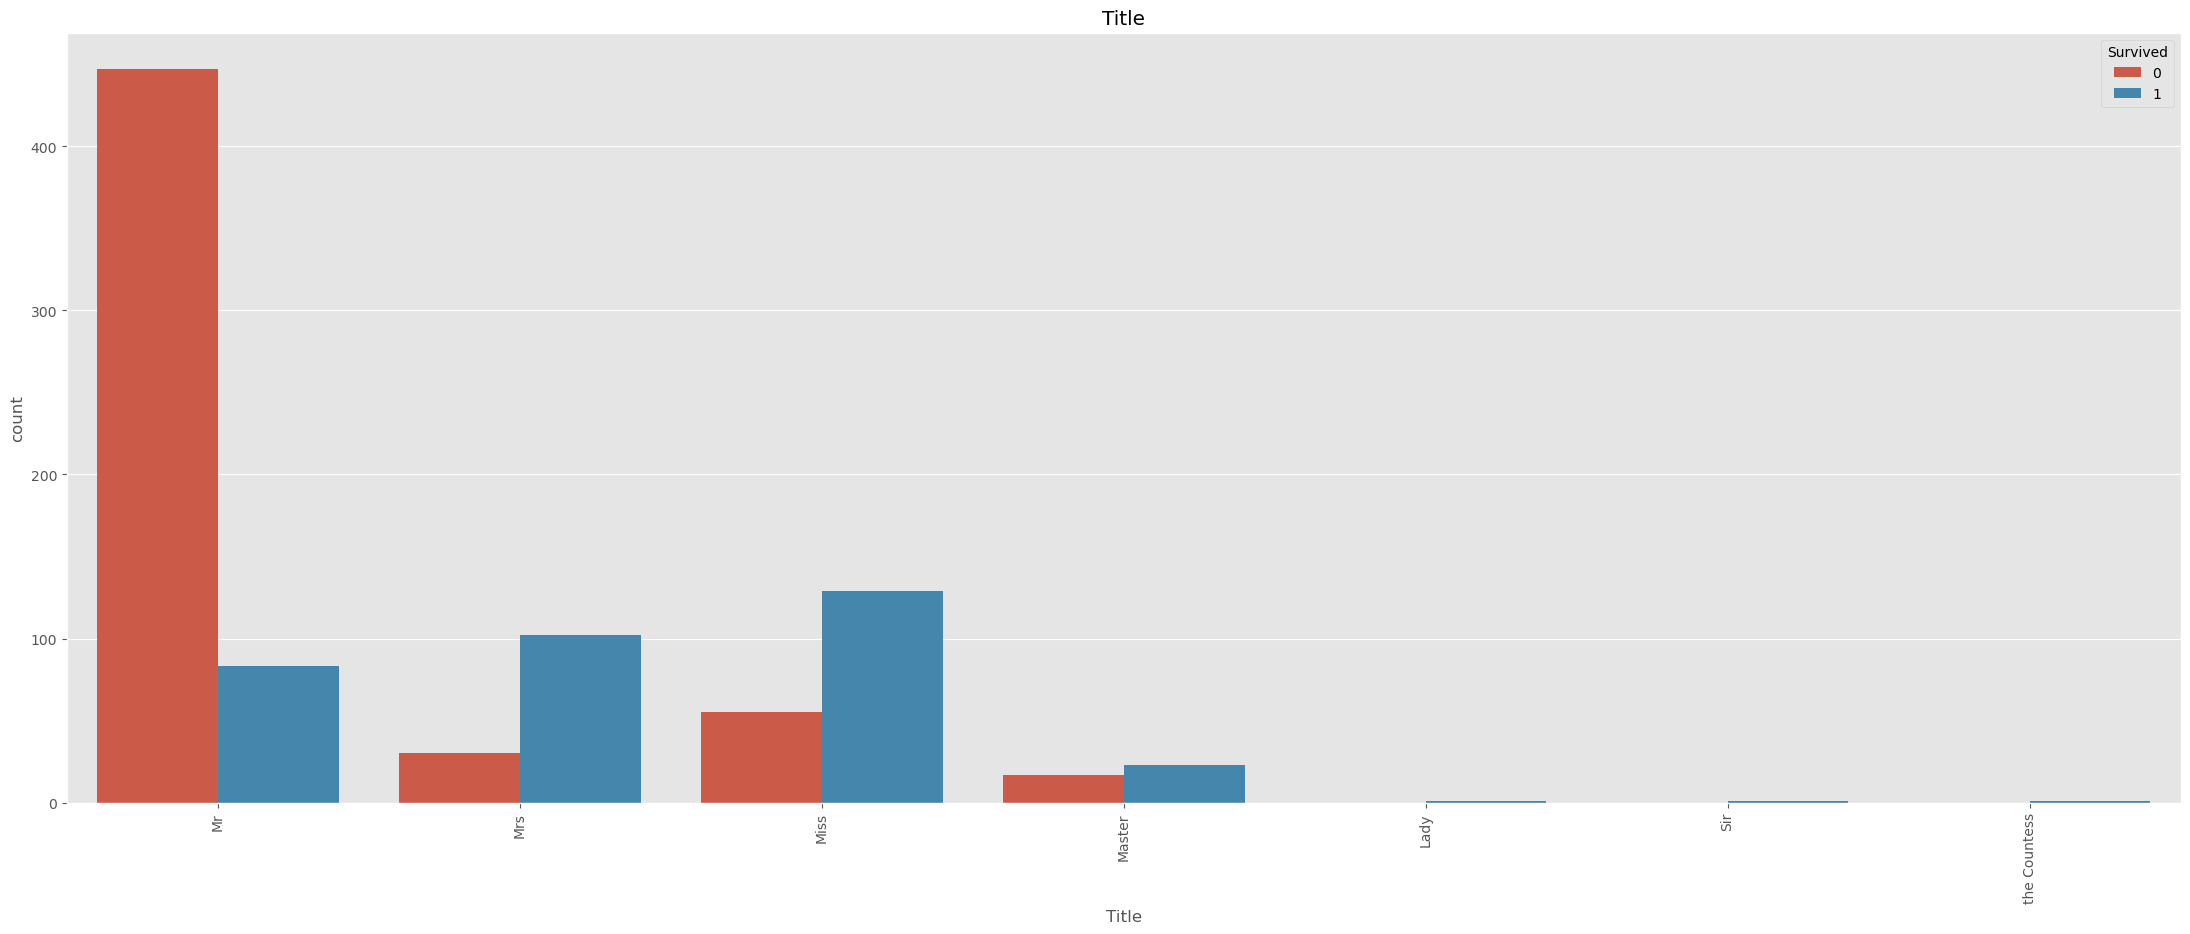

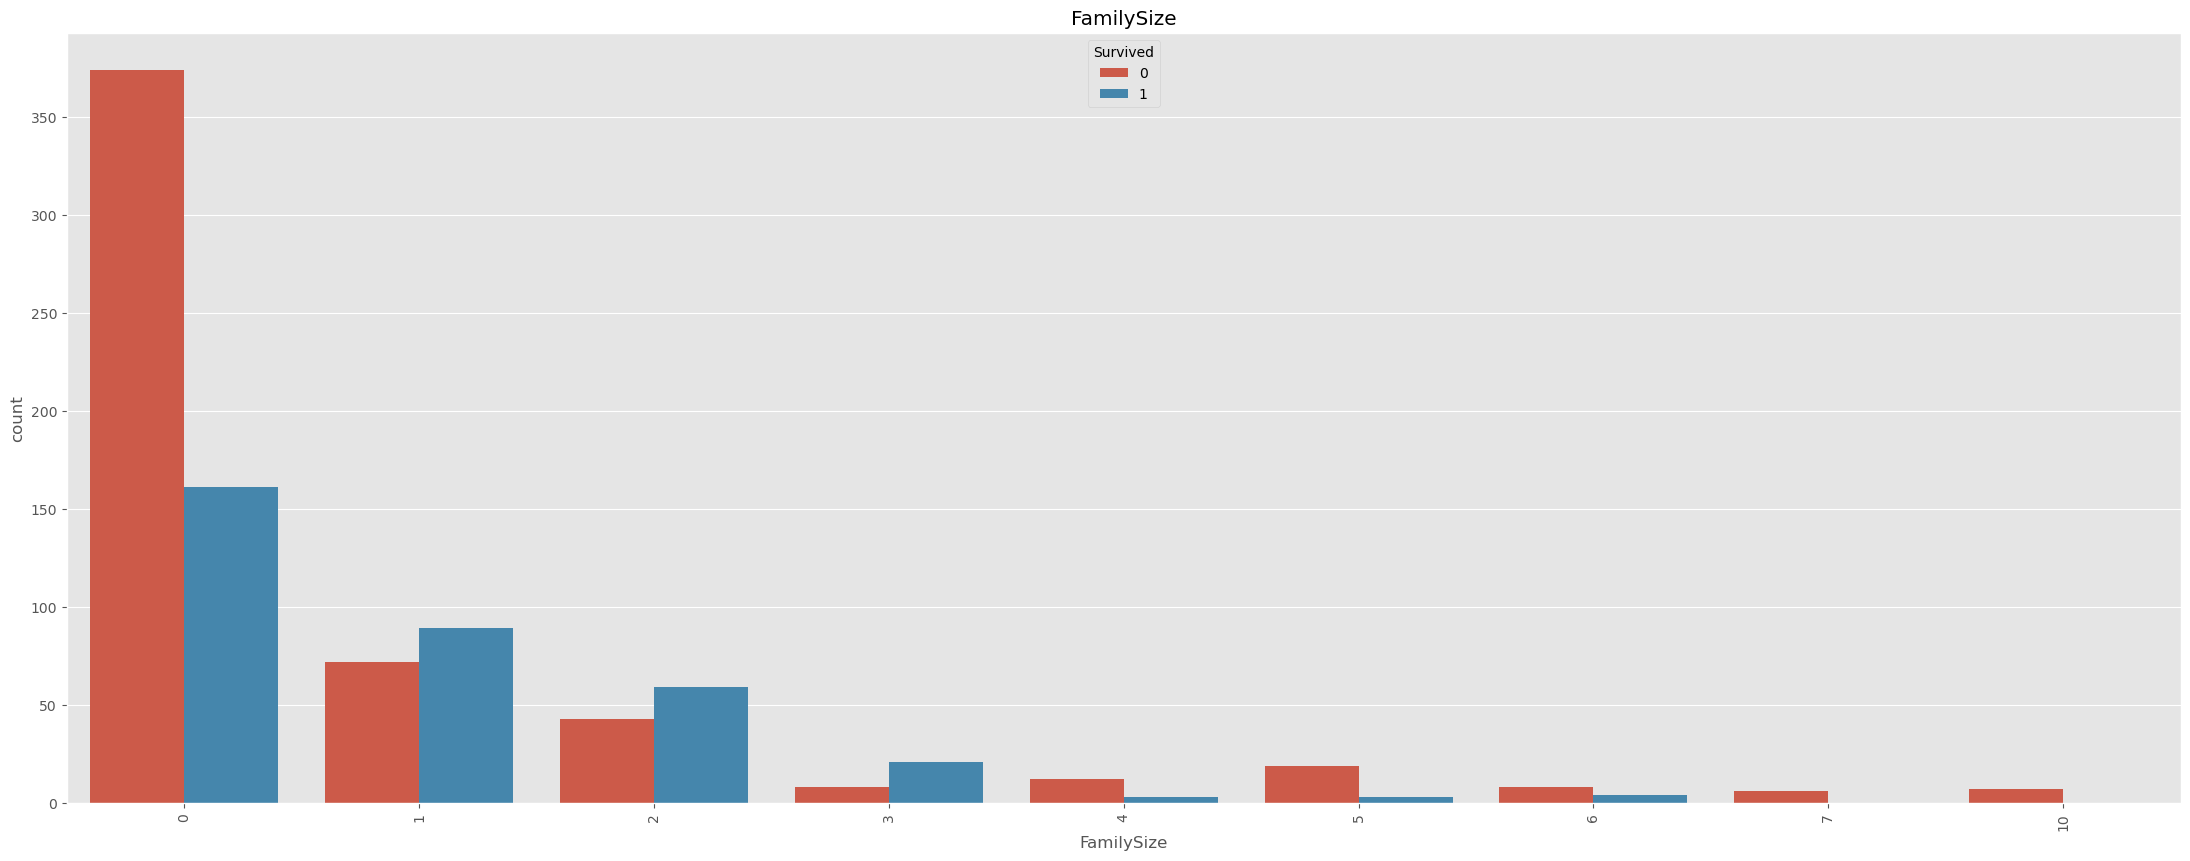

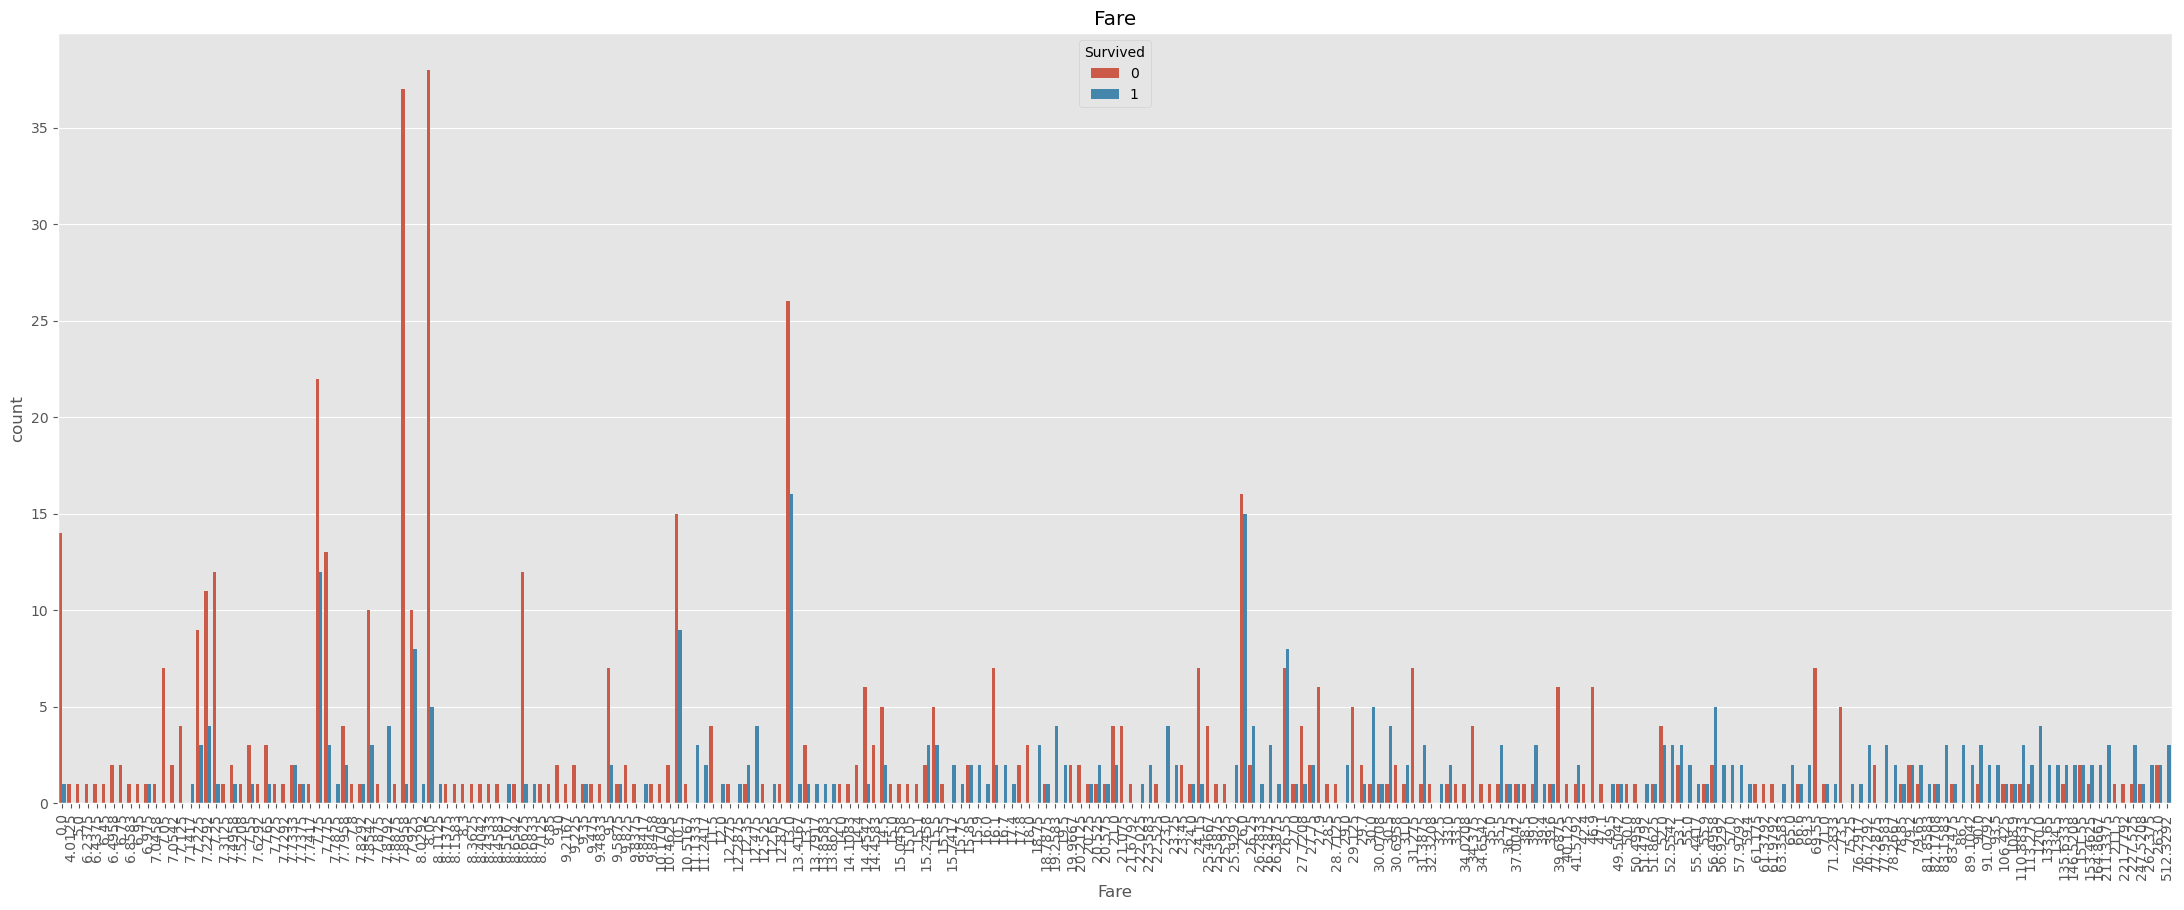

In [31]:
plt.style.use("ggplot")
for column in ['Pclass', 'Sex', 'Age', 'Embarked', 'Title', 'FamilySize', 'Fare']:
    plt.figure(figsize=(60,10))
    plt.subplot(121)
    sns.countplot(train[column], hue=train["Survived"])
    plt.title(column)    
    plt.xticks(rotation=90)

<a id='Data Expolration'></a>
<html>
<body>
    <div style="background-color:rgba(187,126,140, 0.2); border-radius: 5px;">
        <h1 style="color:#4E5166; padding:15px;">2. model implementation</h1>
    </div>
</body>
</html>

## 2.1. Remove skewness

<AxesSubplot:xlabel='Fare', ylabel='Density'>

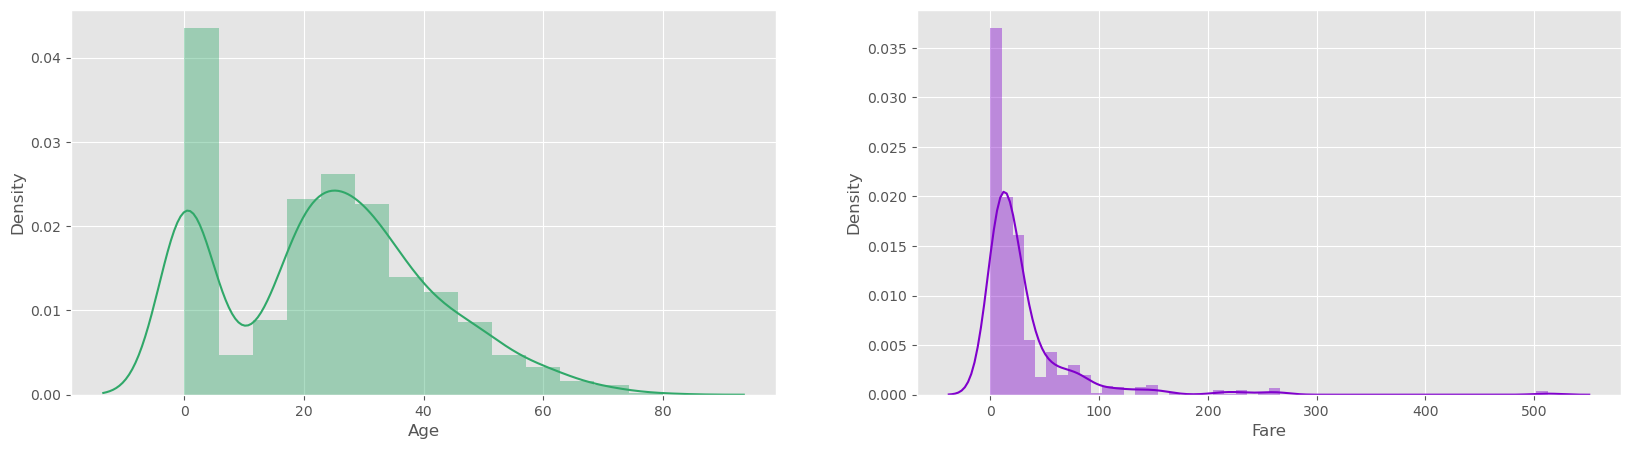

In [32]:
# Plot train distribution
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
sns.distplot(train['Age'], color=(0.188,0.66,0.413))

plt.subplot(1,2,2)
sns.distplot(train['Fare'], color=(0.5,0,0.8))

<AxesSubplot:xlabel='Fare', ylabel='Density'>

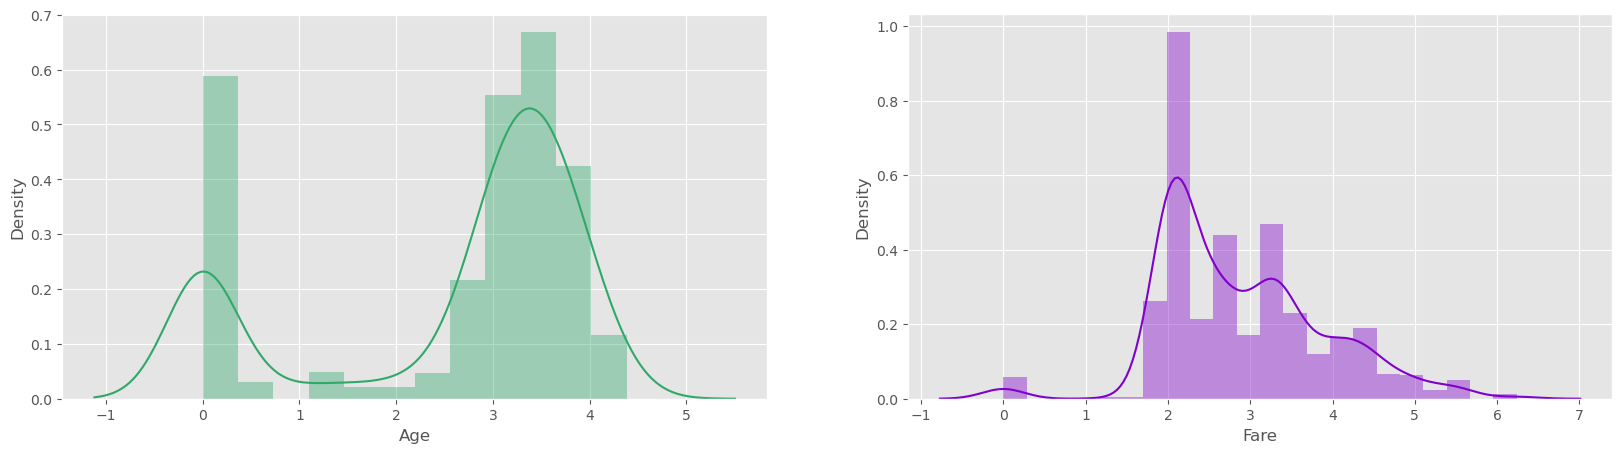

In [33]:
train_log = train.copy()
train_log['Age'] = train_log['Age'].map(lambda i: np.log(i) if i > 0 else 0)
train_log['Fare'] = train_log['Fare'].map(lambda i: np.log(i) if i > 0 else 0)

plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
sns.distplot(train_log['Age'], color=(0.188,0.66,0.413))

plt.subplot(1,2,2)
sns.distplot(train_log['Fare'], color=(0.5,0,0.8))

## 2.2. Data Scaling


Do we need over/under/random sampling?

In [34]:
counter = dict(train_log['Survived'].value_counts())
print(counter)
print('The ratio of survived to not survived is:',round(counter[1]/counter[0]*100,2))

{0: 549, 1: 340}
The ratio of survived to not survived is: 61.93


> Doesn't seem so

In [35]:
X = train_log.drop(columns=['Survived']).set_index('PassengerId')
Y = train_log[['PassengerId','Survived']].set_index('PassengerId')

In [36]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X[["Age","Fare","FamilySize", "Pclass"]])
X_scaled = pd.DataFrame(X_scaled,columns=["Age","Fare","FamilySize","Pclass"], index=X.index)
X_scaled = X_scaled.join(X.drop(columns=["Age","Fare","FamilySize","Pclass"]))

## 2.3. Prediction

### 2.3.1. Catboost

#### Train phase

In [37]:
seed = 7
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y, test_size=test_size, random_state=seed)

In [38]:
print(y_train.value_counts())
print(y_test.value_counts())

Survived
0           375
1           220
dtype: int64
Survived
0           174
1           120
dtype: int64


In [39]:
X_train_enc = X_train.apply(LabelEncoder().fit_transform)
X_train_enc.head()

,Age,Fare,FamilySize,Pclass,Sex,Embarked,Title,Deck
PassengerId,,,,,,,,
745,27,31,0,2,1,2,3,8
659,19,64,0,1,1,2,3,8
841,16,31,0,2,1,2,3,8
718,23,54,0,1,0,2,2,4
796,35,64,0,1,1,2,3,8


In [40]:
model = CatBoostClassifier(verbose=10)

grid = {'learning_rate': [0.03, 0.05, 0.1, 0.2, 0.5],
        'depth': [4, 6, 10, 16],
        'iterations': [5, 10, 15, 20, 50]}

grid_search_result = model.grid_search(grid, 
                                       X=X_train_enc, 
                                       y=y_train, 
                                       plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6748447	test: 0.6758063	best: 0.6758063 (0)	total: 143ms	remaining: 572ms
4:	learn: 0.6132778	test: 0.6184732	best: 0.6184732 (4)	total: 148ms	remaining: 0us

bestTest = 0.6184732402
bestIteration = 4

0:	loss: 0.6184732	best: 0.6184732 (0)	total: 170ms	remaining: 16.8s
0:	learn: 0.6630940	test: 0.6647117	best: 0.6647117 (0)	total: 1.5ms	remaining: 6.01ms
4:	learn: 0.5703807	test: 0.5791741	best: 0.5791741 (4)	total: 6.89ms	remaining: 0us

bestTest = 0.5791740877
bestIteration = 4

1:	loss: 0.5791741	best: 0.5791741 (1)	total: 178ms	remaining: 8.74s
0:	learn: 0.6352911	test: 0.6385973	best: 0.6385973 (0)	total: 1.5ms	remaining: 5.99ms
4:	learn: 0.4953498	test: 0.5114010	best: 0.5114010 (4)	total: 6.62ms	remaining: 0us

bestTest = 0.5114009811
bestIteration = 4

2:	loss: 0.5114010	best: 0.5114010 (2)	total: 186ms	remaining: 6.03s
0:	learn: 0.5863222	test: 0.5931833	best: 0.5931833 (0)	total: 2.1ms	remaining: 8.39ms
4:	learn: 0.4241032	test: 0.4506145	best: 0.4506145 (4)	tota

30:	learn: 0.3269242	test: 0.4603490	best: 0.4260053 (14)	total: 49.7ms	remaining: 30.5ms
40:	learn: 0.3108122	test: 0.4771157	best: 0.4260053 (14)	total: 61ms	remaining: 13.4ms
49:	learn: 0.2835259	test: 0.4742973	best: 0.4260053 (14)	total: 70.4ms	remaining: 0us

bestTest = 0.4260052661
bestIteration = 14

23:	loss: 0.4260053	best: 0.4260053 (13)	total: 820ms	remaining: 2.6s
0:	learn: 0.4868875	test: 0.5059755	best: 0.5059755 (0)	total: 1.16ms	remaining: 57.1ms
10:	learn: 0.3438232	test: 0.4769766	best: 0.4288333 (2)	total: 14.7ms	remaining: 52ms
20:	learn: 0.2928753	test: 0.4939807	best: 0.4288333 (2)	total: 27.6ms	remaining: 38.2ms
30:	learn: 0.2319474	test: 0.5002519	best: 0.4288333 (2)	total: 42.3ms	remaining: 25.9ms
40:	learn: 0.2000557	test: 0.5366588	best: 0.4288333 (2)	total: 58.7ms	remaining: 12.9ms
49:	learn: 0.1710059	test: 0.5621373	best: 0.4288333 (2)	total: 73.2ms	remaining: 0us

bestTest = 0.4288333064
bestIteration = 2

24:	loss: 0.4288333	best: 0.4260053 (13)	total: 

10:	learn: 0.4013718	test: 0.4456824	best: 0.4456824 (10)	total: 28.6ms	remaining: 102ms
20:	learn: 0.3567295	test: 0.4333158	best: 0.4333158 (20)	total: 51.3ms	remaining: 70.8ms
30:	learn: 0.3311784	test: 0.4284553	best: 0.4254730 (27)	total: 72ms	remaining: 44.1ms
40:	learn: 0.3116933	test: 0.4403250	best: 0.4254730 (27)	total: 88.4ms	remaining: 19.4ms
49:	learn: 0.2988198	test: 0.4436601	best: 0.4254730 (27)	total: 105ms	remaining: 0us

bestTest = 0.4254730316
bestIteration = 27

47:	loss: 0.4254730	best: 0.4160750 (29)	total: 1.74s	remaining: 1.89s
0:	learn: 0.5863222	test: 0.5931833	best: 0.5931833 (0)	total: 2.19ms	remaining: 108ms
10:	learn: 0.3527575	test: 0.4267525	best: 0.4267525 (10)	total: 23.2ms	remaining: 82.4ms
20:	learn: 0.3173971	test: 0.4500353	best: 0.4267525 (10)	total: 48.6ms	remaining: 67.1ms
30:	learn: 0.2858851	test: 0.4661748	best: 0.4267525 (10)	total: 65.7ms	remaining: 40.3ms
40:	learn: 0.2472370	test: 0.4776144	best: 0.4267525 (10)	total: 86ms	remaining: 18.

10:	learn: 0.2150799	test: 0.4623235	best: 0.4339896 (2)	total: 112ms	remaining: 91.4ms
19:	learn: 0.1600938	test: 0.4814168	best: 0.4339896 (2)	total: 183ms	remaining: 0us

bestTest = 0.4339895923
bestIteration = 2

69:	loss: 0.4339896	best: 0.4160750 (29)	total: 3.91s	remaining: 1.68s
0:	learn: 0.6748447	test: 0.6758063	best: 0.6758063 (0)	total: 2.15ms	remaining: 105ms
10:	learn: 0.5307074	test: 0.5465316	best: 0.5465316 (10)	total: 72.6ms	remaining: 257ms
20:	learn: 0.4506631	test: 0.4837361	best: 0.4837361 (20)	total: 140ms	remaining: 193ms
30:	learn: 0.4149390	test: 0.4555838	best: 0.4555838 (30)	total: 172ms	remaining: 105ms
40:	learn: 0.3824780	test: 0.4421129	best: 0.4421129 (40)	total: 253ms	remaining: 55.5ms
49:	learn: 0.3635418	test: 0.4327536	best: 0.4327536 (49)	total: 318ms	remaining: 0us

bestTest = 0.4327536011
bestIteration = 49

70:	loss: 0.4327536	best: 0.4160750 (29)	total: 4.23s	remaining: 1.73s
0:	learn: 0.6630940	test: 0.6647117	best: 0.6647117 (0)	total: 2.6ms	

19:	learn: 0.4506199	test: 0.4955385	best: 0.4955385 (19)	total: 1.26s	remaining: 0us

bestTest = 0.4955384633
bestIteration = 19

90:	loss: 0.4955385	best: 0.4160750 (29)	total: 21.3s	remaining: 2.1s
0:	learn: 0.6630940	test: 0.6647117	best: 0.6647117 (0)	total: 1.97ms	remaining: 37.5ms
10:	learn: 0.4628001	test: 0.4987130	best: 0.4987130 (10)	total: 315ms	remaining: 257ms
19:	learn: 0.3859974	test: 0.4505466	best: 0.4505466 (19)	total: 1.02s	remaining: 0us

bestTest = 0.4505465945
bestIteration = 19

91:	loss: 0.4505466	best: 0.4160750 (29)	total: 22.3s	remaining: 1.94s
0:	learn: 0.6352911	test: 0.6385973	best: 0.6385973 (0)	total: 1.13ms	remaining: 21.5ms
10:	learn: 0.3663525	test: 0.4427455	best: 0.4427455 (10)	total: 745ms	remaining: 610ms
19:	learn: 0.3029945	test: 0.4380069	best: 0.4354822 (14)	total: 1.07s	remaining: 0us

bestTest = 0.4354821673
bestIteration = 14

92:	loss: 0.4354822	best: 0.4160750 (29)	total: 23.4s	remaining: 1.76s
0:	learn: 0.5863222	test: 0.5931833	best: 0

In [41]:
print(" Results from Grid Search " )
grid_search_result

 Results from Grid Search 


{'params': {'depth': 6, 'iterations': 5, 'learning_rate': 0.5},
 'cv_results': defaultdict(list,
             {'iterations': [0, 1, 2, 3, 4],
              'test-Logloss-mean': [0.5124317205760773,
               0.4479984382657025,
               0.44102604165847525,
               0.43284013491376955,
               0.4351461224699709],
              'test-Logloss-std': [0.03664306399347675,
               0.03110707557634716,
               0.031112682033890223,
               0.03743399862821907,
               0.04383111040978316],
              'train-Logloss-mean': [0.5072757415440918,
               0.41724834217442774,
               0.3848318346318349,
               0.3649348590389138,
               0.35075907903545867],
              'train-Logloss-std': [0.035920131191357466,
               0.029508250195289736,
               0.034270168888837306,
               0.027745607665575198,
               0.024846321291792386]})}

In [42]:
grid_search_result['params']

{'depth': 6, 'iterations': 5, 'learning_rate': 0.5}

In [43]:
cat_index = [X_scaled.columns.get_loc(i) for i in ["Sex","Embarked","Title","Deck"]]

In [44]:
model = CatBoostClassifier(iterations=5, learning_rate=0.5, depth=6, verbose=10)

In [45]:
%%time
model.fit(X_train, y_train, cat_index)

0:	learn: 0.5540404	total: 27.2ms	remaining: 109ms
4:	learn: 0.4097471	total: 91.3ms	remaining: 0us
Wall time: 119 ms


In [46]:
%%time
y_pred = model.predict(X_test)

Wall time: 1e+03 µs


In [47]:
%%time
# Get predicted probabilities for each class
preds_proba = model.predict_proba(X_test)
preds_proba

Wall time: 3 ms


array([[0.64921265, 0.35078735],
       [0.76741484, 0.23258516],
       [0.87623192, 0.12376808],
       [0.15922443, 0.84077557],
       [0.65240068, 0.34759932],
       [0.64921265, 0.35078735],
       [0.74495495, 0.25504505],
       [0.880843  , 0.119157  ],
       [0.43885265, 0.56114735],
       [0.71916572, 0.28083428],
       [0.5384267 , 0.4615733 ],
       [0.73105891, 0.26894109],
       [0.31475641, 0.68524359],
       [0.1295311 , 0.8704689 ],
       [0.83931759, 0.16068241],
       [0.69168568, 0.30831432],
       [0.46990063, 0.53009937],
       [0.87464224, 0.12535776],
       [0.67463575, 0.32536425],
       [0.09716733, 0.90283267],
       [0.71943452, 0.28056548],
       [0.58422182, 0.41577818],
       [0.1045621 , 0.8954379 ],
       [0.71095944, 0.28904056],
       [0.8164503 , 0.1835497 ],
       [0.43885265, 0.56114735],
       [0.880843  , 0.119157  ],
       [0.880843  , 0.119157  ],
       [0.880843  , 0.119157  ],
       [0.880843  , 0.119157  ],
       [0.

In [48]:
%%time
# Get predicted RawFormulaVal
preds_raw = model.predict(X_test, prediction_type='RawFormulaVal')

Wall time: 2.92 ms


In [49]:
%%time
# evaluate predictions
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("Precision: %.2f%%" % (precision * 100.0))
print("Recall: %.2f%%" % (recall * 100.0))

Accuracy: 81.29%
Precision: 82.83%
Recall: 68.33%
Wall time: 3.93 ms


In [50]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[157,  17],
       [ 38,  82]], dtype=int64)

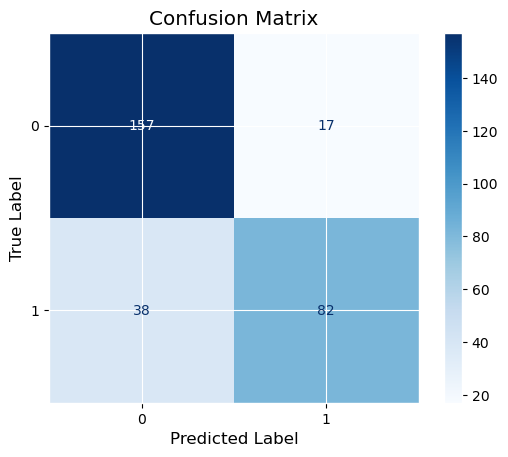

In [51]:
color = 'black'
matrix = plot_confusion_matrix(model, X_test, y_test, cmap=plt.cm.Blues)
matrix.ax_.set_title('Confusion Matrix', color=color)
plt.xlabel('Predicted Label', color=color)
plt.ylabel('True Label', color=color)
plt.gcf().axes[0].tick_params(colors=color)
plt.gcf().axes[1].tick_params(colors=color)
plt.show()

#### Predict phase

In [52]:
model = CatBoostClassifier(iterations=5, learning_rate=0.5, depth=6, verbose=10)
model.fit(X_scaled, Y, cat_index)

0:	learn: 0.5498123	total: 14.9ms	remaining: 59.7ms
4:	learn: 0.4182784	total: 71.6ms	remaining: 0us


- Preparing test data:

In [53]:
test['PassengerId'] = test['PassengerId'].apply(str)
test.dropna(subset='Embarked', inplace=True)
test['Cabin'].fillna('Unknown', inplace = True)
test.loc[test['Age'] <1, 'Age'] = 0
test['Age'].fillna(0, inplace = True)
temp = test['Name'].apply(lambda x: x.split(','))
test['LastName'] = temp.apply(lambda x: x[0])
temp = temp.apply(lambda x: x[1].split('.'))
test['FirstName'] = temp.apply(lambda x: x[1][1:])
test['Title'] = temp.apply(lambda x: x[0][1:])
test.drop(columns=['Name'], inplace = True)
test['Title']= test.apply(replace_titles, axis=1)
cabin_list = ['A', 'B', 'C', 'D', 'E', 'F', 'T', 'G', 'Unknown']
test['Deck']=test['Cabin'].map(lambda x: substrings_in_string(x, cabin_list))
test['FamilySize']=test['SibSp']+test['Parch']
test.drop(columns=['Parch', 'SibSp', 'Cabin', 'LastName', 'FirstName', 'Ticket'], inplace=True)
test.head(3)
test['Age'] = test['Age'].apply(int)
test.set_index('PassengerId', inplace=True)

<AxesSubplot:xlabel='Fare', ylabel='Density'>

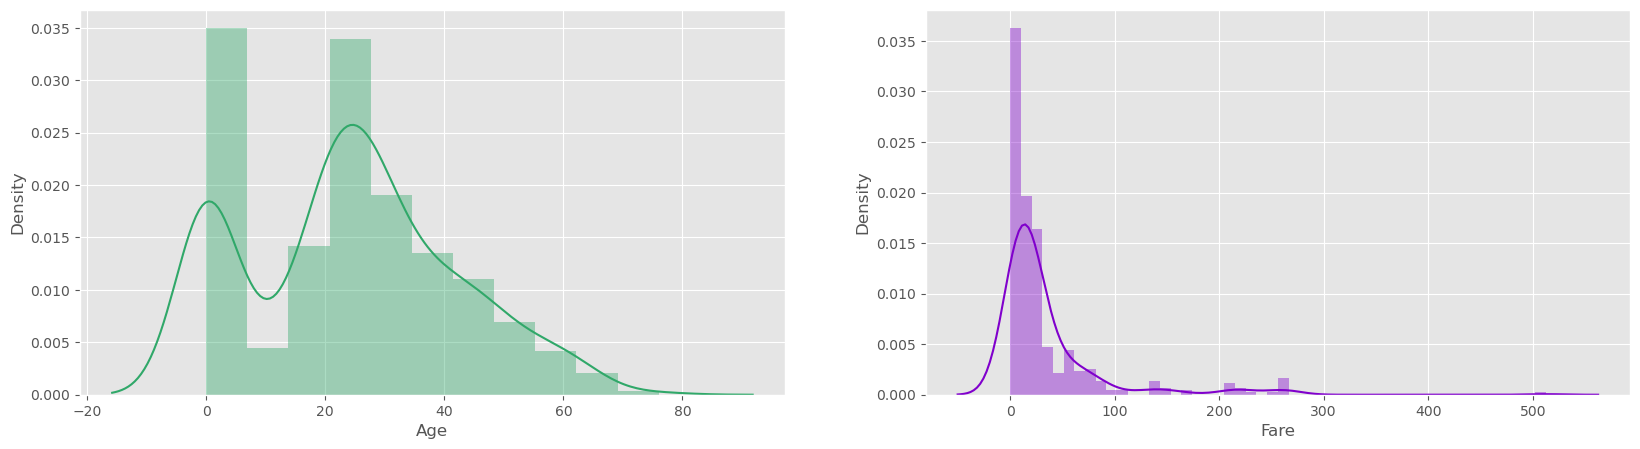

In [54]:
# Plot test distribution
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
sns.distplot(test['Age'], color=(0.188,0.66,0.413))

plt.subplot(1,2,2)
sns.distplot(test['Fare'], color=(0.5,0,0.8))

<AxesSubplot:xlabel='Fare', ylabel='Density'>

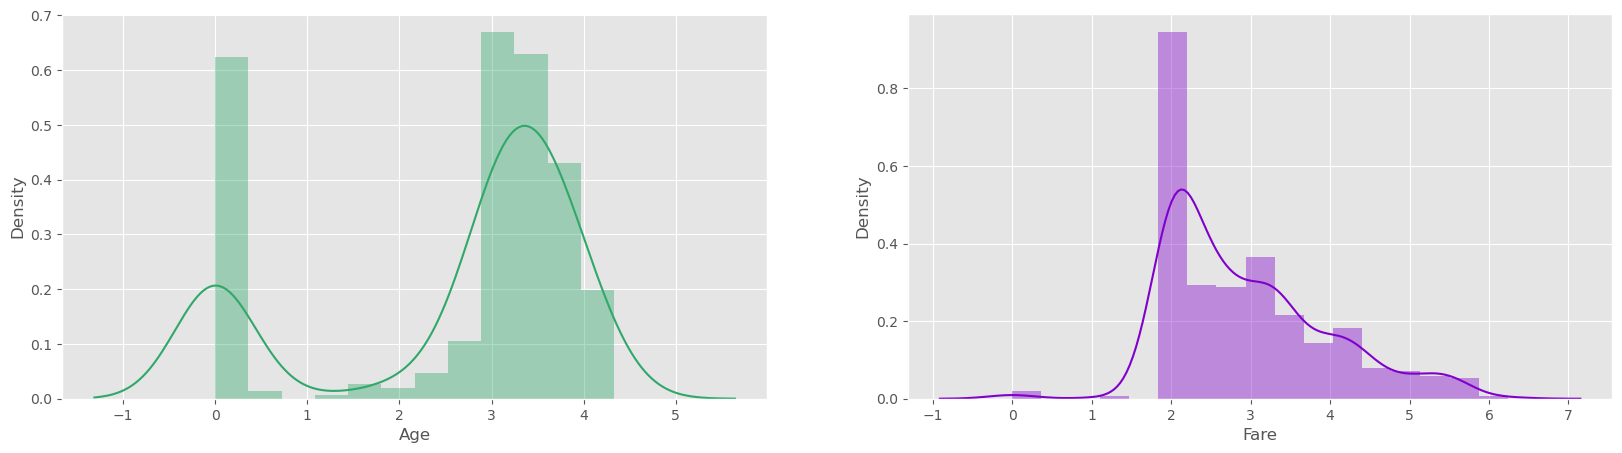

In [55]:
test_log = test.copy()
test_log['Age'] = test_log['Age'].map(lambda i: np.log(i) if i > 0 else 0)
test_log['Fare'] = test_log['Fare'].map(lambda i: np.log(i) if i > 0 else 0)

plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
sns.distplot(test_log['Age'], color=(0.188,0.66,0.413))

plt.subplot(1,2,2)
sns.distplot(test_log['Fare'], color=(0.5,0,0.8))

In [56]:
scaler = StandardScaler()
test_scaled = scaler.fit_transform(test[["Age","Fare","FamilySize", "Pclass"]])
test_scaled = pd.DataFrame(test_scaled,columns=["Age","Fare","FamilySize","Pclass"], index=test.index)
test_scaled = test_scaled.join(test.drop(columns=["Age","Fare","FamilySize","Pclass"]))

In [57]:
# reorder column in case that they dont match with train set
test_scaled = test_scaled[X_scaled.columns]

In [58]:
result = pd.DataFrame(model.predict(test_scaled), index=test_scaled.index, columns=['Survived']).reset_index()

In [59]:
result['Survived'].value_counts()

0    254
1    164
Name: Survived, dtype: int64

In [60]:
result.to_csv("result.csv",index=False)

### 2.3.2. XGBOOST

In [61]:
X_scaled_enc = X_scaled.drop(columns=['Sex','Embarked', 'Title', 'Deck']).copy()
for i in ['Sex','Embarked', 'Title', 'Deck']:
    s = pd.get_dummies(X_scaled[i])
    X_scaled_enc = X_scaled_enc.merge(s, on='PassengerId', how='inner')  
    

In [62]:
seed = 7
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(X_scaled_enc, Y, test_size=test_size, random_state=seed)

In [63]:


model = XGBClassifier()

model = XGBClassifier(max_depth =20, eta= 0.0001, objective= 'binary:logistic',nthread= 4)
model.fit(X_train, y_train, eval_metric='auc')

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False, eta=0.0001,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=9.99999975e-05,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=20, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=4, nthread=4, num_parallel_tree=1, ...)

In [64]:
%%time
y_pred = model.predict(X_test)

Wall time: 3.83 ms


In [65]:
%%time
# evaluate predictions
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("Precision: %.2f%%" % (precision * 100.0))
print("Recall: %.2f%%" % (recall * 100.0))

Accuracy: 81.29%
Precision: 77.31%
Recall: 76.67%
Wall time: 3.07 ms


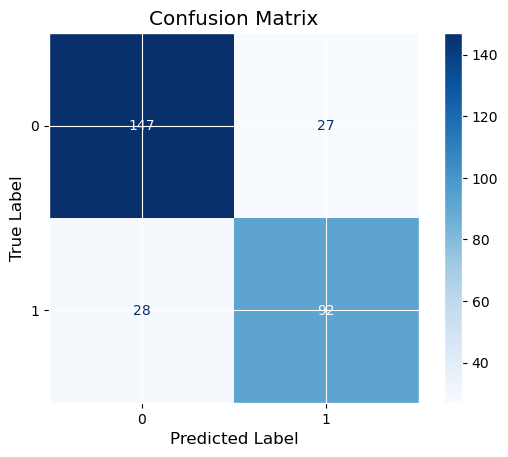

In [66]:
color = 'black'
matrix = plot_confusion_matrix(model, X_test, y_test, cmap=plt.cm.Blues)
matrix.ax_.set_title('Confusion Matrix', color=color)
plt.xlabel('Predicted Label', color=color)
plt.ylabel('True Label', color=color)
plt.gcf().axes[0].tick_params(colors=color)
plt.gcf().axes[1].tick_params(colors=color)
plt.show()

#### Predict phase

In [67]:
X_test_scaled_enc = test_scaled.drop(columns=['Sex','Embarked', 'Title', 'Deck']).copy()
for i in ['Sex','Embarked', 'Title', 'Deck']:
    s = pd.get_dummies(test_scaled[i])
    X_test_scaled_enc = X_test_scaled_enc.merge(s, on='PassengerId', how='inner')  

In [68]:
a = np.intersect1d(X_test_scaled_enc.columns, X_scaled_enc.columns)
b = list(set(X_scaled_enc).difference(X_test_scaled_enc))
X_test_scaled_enc_filter = X_test_scaled_enc[a]
X_test_scaled_enc_filter[b]=0
X_test_scaled_enc_filter=X_test_scaled_enc_filter[X_scaled_enc.columns]

In [69]:
%%time
model.fit(X_scaled_enc, Y, eval_metric='auc')
result_xgb = pd.DataFrame(model.predict(X_test_scaled_enc_filter), index=X_test_scaled_enc_filter.index, columns=['Survived']).reset_index()

Wall time: 128 ms


In [70]:
result_xgb['Survived'].value_counts()

0    254
1    164
Name: Survived, dtype: int64

In [71]:
result_xgb.to_csv("result_xgb.csv",index=False)